In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
import time
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

!pip install gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine = 'python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] !=3]  #Remove Meutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

# using 10000 review for model training and evaluation
df = df.sample(15000)
df.head()

,Text,Score,label
9137,A very nice flavor with no after-taste. It giv...,5,1
553606,I love the flavor of these peanut butter grano...,5,1
186545,I bought this bread mix based on the reviews a...,1,0
237308,looking at most of the reviews saying that a q...,5,1
188779,We haven't had these gluten-free animal cracke...,5,1


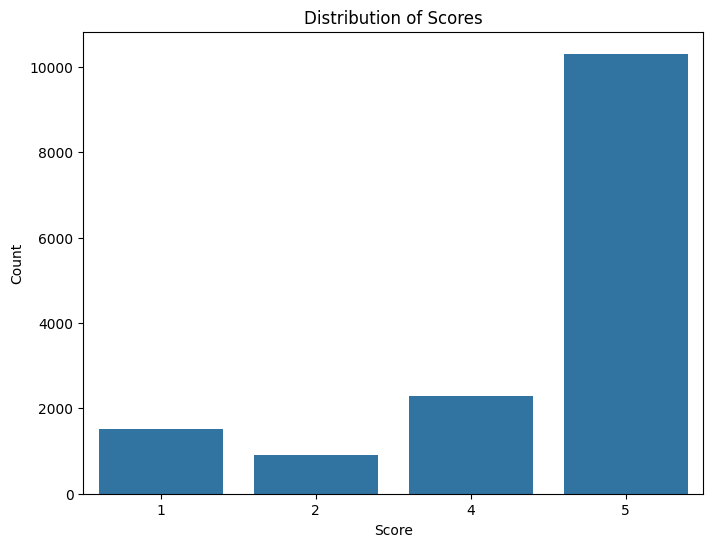

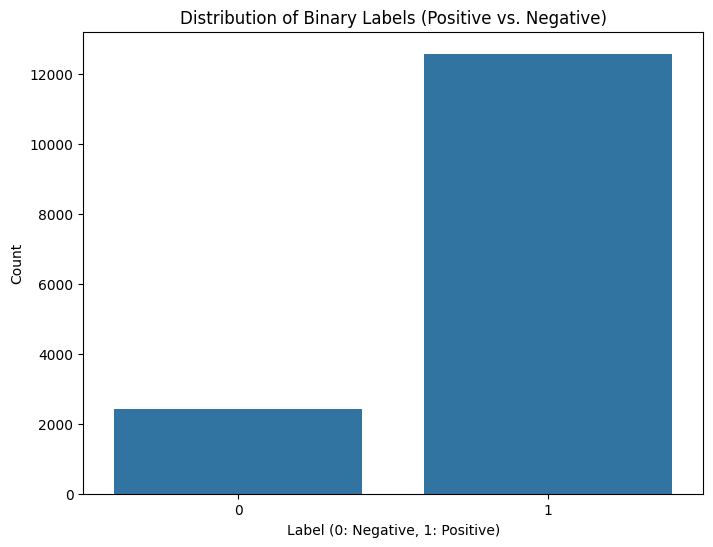

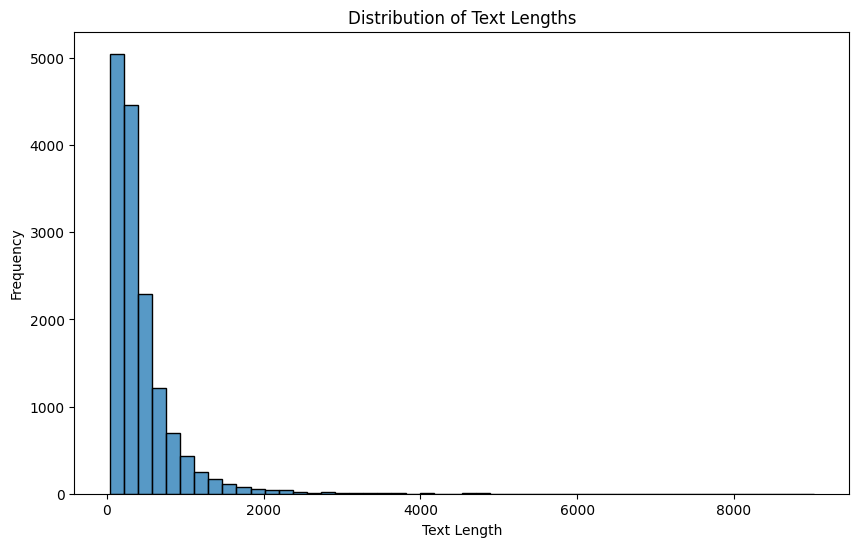

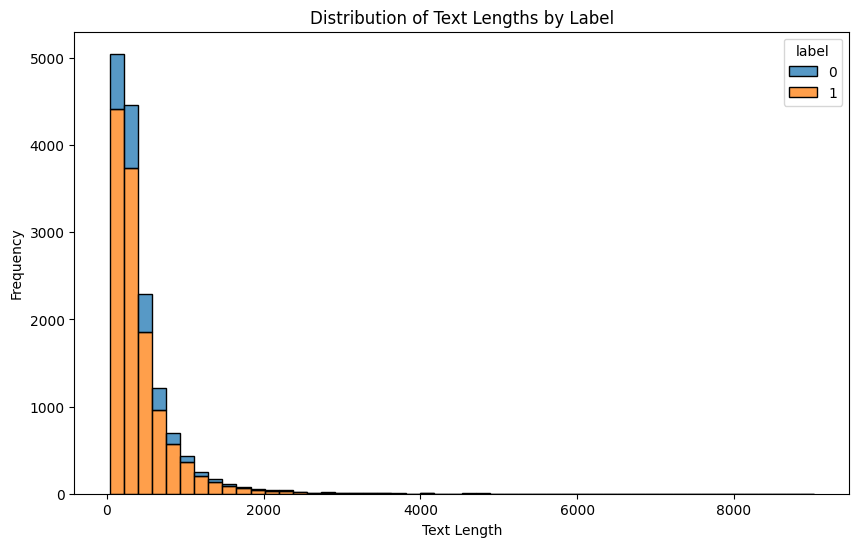

In [3]:
import matplotlib.pyplot as plt
# Check the distribution of scores
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check the distribution of the new binary label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Binary Labels (Positive vs. Negative)')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Distribution of review length
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of text length by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, multiple="stack")
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
df.shape

(15000, 4)

In [5]:
lemmatizer =  WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
  text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
  text = text.split()
  tokens = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
  return ' '.join(tokens)

df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

In [6]:
df.cleaned_text.head(5)

,cleaned_text
9137,nice flavor taste give nice fragrance brewing ...
553606,love flavor peanut butter granola bar quick pi...
186545,bought bread mix based review therefore expect...
237308,looking review saying quantity package opened ...
188779,gluten free animal cracker year reason local h...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = 5000)
x_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_tfidf,  y, test_size = 0.2 , random_state = 42)

In [9]:
model = Sequential()
model.add(Dense(128, input_shape=(x_train.shape[1],), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy'])

# Step 5: Train the model
start_train = time.time()
history = model.fit(x_train, y_train, epochs=2, batch_size=128, validation_split=0.1)
end_train = time.time()

# Step 6: Evaluate
loss, accuracy = model.evaluate(x_test, y_test)
print("Accuracy:", accuracy)
print("Training Time:", end_train - start_train)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8289 - loss: 0.5142 - val_accuracy: 0.8400 - val_loss: 0.3190
Epoch 2/2
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8610 - loss: 0.2426 - val_accuracy: 0.8942 - val_loss: 0.2678
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052 - loss: 0.2539
Accuracy: 0.9089999794960022
Training Time: 5.879679441452026


In [12]:
start_test = time.time()
loss, accuracy = model.evaluate(x_test, y_test)
end_test = time.time()

print("Testing Time:", end_test - start_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9052 - loss: 0.2539
Testing Time: 0.45168352127075195


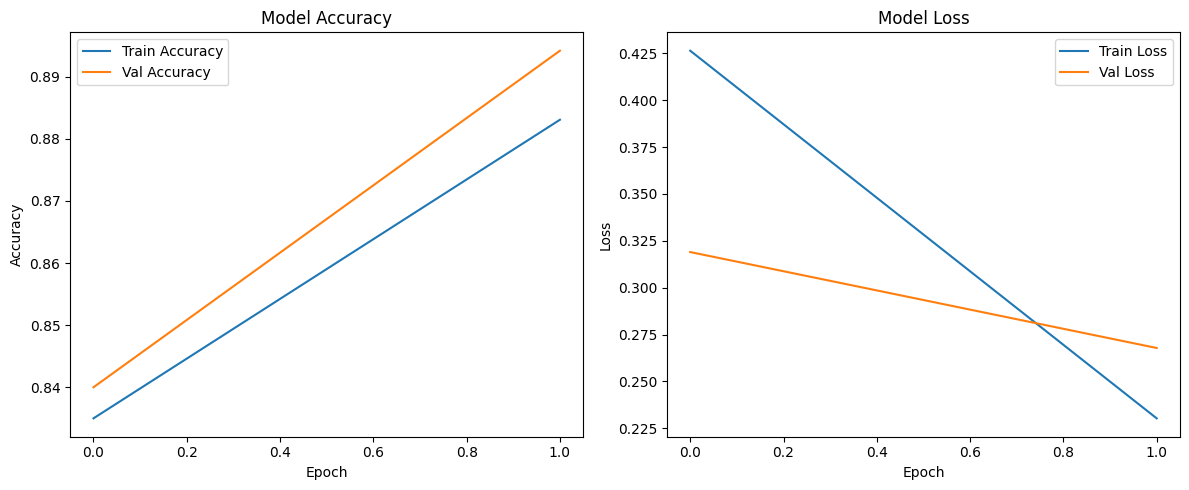

In [10]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.78      0.57      0.66       460
           1       0.93      0.97      0.95      2540

    accuracy                           0.91      3000
   macro avg       0.85      0.77      0.80      3000
weighted avg       0.90      0.91      0.90      3000



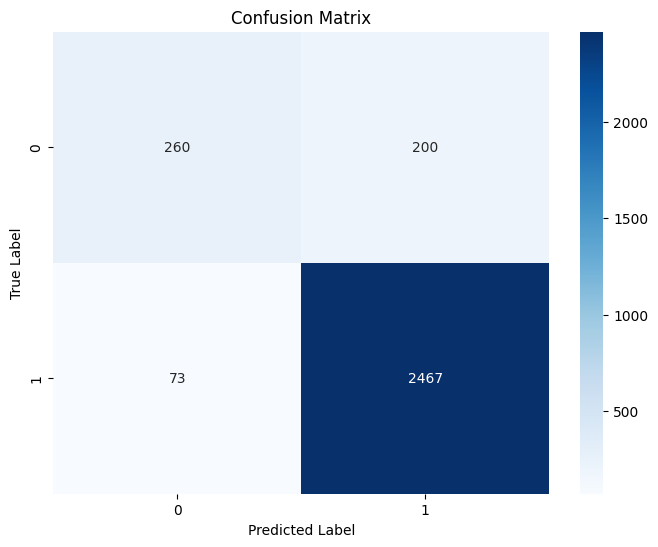

In [11]:
# precision, recall, F1-score, confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# precision, recall, F1-score, confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Generate predictions
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")


print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()